In [1]:
import requests, json, time

# ArcGIS REST endpoint for Utah Mining Claims Listings Per Section
LAYER_URL = "https://services5.arcgis.com/aEZWbbQHTw7fmHLY/ArcGIS/rest/services/UtahMiningClaims/FeatureServer/5/query"

def fetch_all_geojson(where="1=1", out_fields="*"):
    sess = requests.Session()
    sess.headers.update({"Accept-Encoding": "gzip, deflate", "User-Agent": "py-geojson-grabber"})
    
    params = {
        "where": where,
        "outFields": out_fields,
        "returnGeometry": "true",
        "f": "geojson",        # Request GeoJSON
        "outSR": "4326",       # Reproject to WGS84 lon/lat
        "orderByFields": "OBJECTID ASC",
        "resultRecordCount": 1000,
        "resultOffset": 0
    }

    all_features = []
    fc_template = None

    while True:
        r = sess.get(LAYER_URL, params=params, timeout=60)
        r.raise_for_status()
        page = r.json()

        if fc_template is None:
            fc_template = {k: v for k, v in page.items() if k != "features"}

        features = page.get("features", [])
        all_features.extend(features)

        if len(features) < params["resultRecordCount"]:
            break

        params["resultOffset"] += params["resultRecordCount"]
        time.sleep(0.2)  # be nice to server

    fc = dict(fc_template)
    fc["features"] = all_features
    return fc

# Fetch everything
geojson_data = fetch_all_geojson()


In [4]:
# Save to file
output_file = "utah_mining_claims_per_section.geojson"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(geojson_data, f)

print(f"Wrote {len(geojson_data['features'])} features to {output_file}")

Wrote 8207 features to utah_mining_claims_per_section.geojson


In [5]:
import geopandas as gpd

gdf = gpd.read_file(output_file)
display(gdf)


,OBJECTID,Join_Count,QSecID,JoinOrigin,AdminState,Case_Land_Remarks,Customer_Id,State,LocDate,Shape__Area,Shape__Length,geometry
0,1,1,26 0420S 0190W 025 NE,NE,UT,None,2419618.0,UT,1535788800000,648146.871582,3220.302775,"POLYGON ((-113.92382 37.10288, -113.92382 37.1..."
1,4,3,26 0430S 0180W 004 NE,NE,UT,None,6492605.0,UT,1678003200000,648190.154053,3220.410297,"POLYGON ((-113.8698 37.07383, -113.8698 37.081..."
2,5,4,26 0420S 0170W 034 NE,NE,UT,None,2356101.0,UT,1295596800000,648292.032471,3220.663370,"POLYGON ((-113.74304 37.08827, -113.74304 37.0..."
3,6,7,26 0430S 0180W 002 NE,NE,UT,None,2398850.0,UT,1741334400000,648218.995850,3220.481944,"POLYGON ((-113.83357 37.07381, -113.83357 37.0..."
4,7,13,26 0430S 0180W 001 NE,NE,UT,None,2398850.0,UT,1741334400000,648233.545410,3220.518086,"POLYGON ((-113.81546 37.0738, -113.81546 37.08..."
...,...,...,...,...,...,...,...,...,...,...,...,...
8202,9092,10,26 0100S 0080W 037,Center,UT,None,10270085,UT,1552896000000,127374.446533,1265.370026,"POLYGON ((-112.6935 39.97489, -112.69335 39.97..."
8203,9093,6,26 0090S 0080W 039,Center,UT,None,6473330.0,UT,1603008000000,127366.782715,1265.331954,"POLYGON ((-112.72978 40.01926, -112.72963 40.0..."
8204,9094,12,26 0090S 0080W 046,Center,UT,None,6473330.0,UT,1603008000000,127366.958252,1265.332827,"POLYGON ((-112.72955 40.00893, -112.7294 40.00..."
8205,9095,10,26 0090S 0080W 047,Center,UT,None,6473330.0,UT,1603008000000,127369.494385,1265.345423,"POLYGON ((-112.71649 40.00931, -112.71634 40.0..."


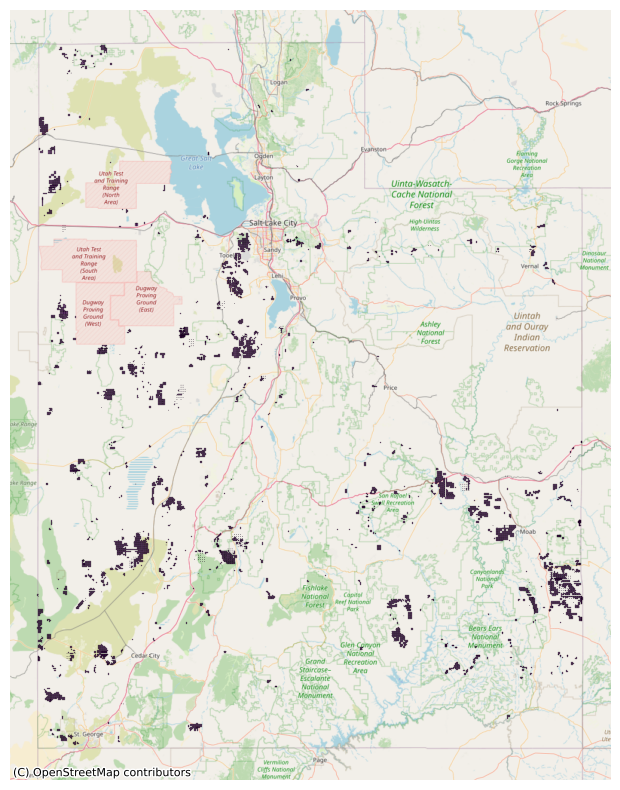

In [6]:
import matplotlib.pyplot as plt
import contextily as ctx

# Make sure in Web Mercator (EPSG:3857) for tile compatibility
if gdf.crs is None or gdf.crs.to_epsg() != 3857:
    gdf = gdf.to_crs(3857)

fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column="Join_Count",
    linewidth=0.2,
    edgecolor="black",
    alpha=0.6,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.show()



In [ ]:
# Enable widgets in VS Code / Codespaces if needed
import os
os.environ.get("JUPYTER_ENABLE_LAB")  # Just to show we're in lab-like env

# If widgets don't render, in VS Code: View → Command Palette → "Python: Reload Window"


Note: you may need to restart the kernel to use updated packages.


In [7]:
# New cell — imports and make sure gdf is WGS84 for web maps
from ipyleaflet import Map, GeoJSON, DrawControl, LayersControl, basemaps, WidgetControl
from ipywidgets import HTML, Button, HBox, VBox, Output, Dropdown
from shapely.geometry import shape, box
import geopandas as gpd
import json

# Ensure your existing gdf is in EPSG:4326 (lat/lon)
if gdf.crs is None or gdf.crs.to_epsg() != 4326:
    gdf = gdf.to_crs(4326)


In [ ]:
# interactive map with draw + export

# Center map on your data
minx, miny, maxx, maxy = gdf.total_bounds
center = ((miny + maxy)/2, (minx + maxx)/2)

m = Map(center=center, zoom=7, basemap=basemaps.OpenStreetMap.Mapnik)

# Add the full dataset as a GeoJSON overlay (simple style)
gj = GeoJSON(
    data=json.loads(gdf.to_json()),
    style={"color": "black", "weight": 1, "fillOpacity": 0.3},
    name="Utah Mining Claims (all)"
)
m.add_layer(gj)

# Draw control: rectangle & polygon selection
draw = DrawControl(
    rectangle={"shapeOptions": {"color": "#ff7800", "weight": 1}},
    polygon={"shapeOptions": {"color": "#ff0000", "weight": 1}},
    circlemarker={}, polyline={}, circle={}  # disable extras
)
m.add_control(draw)

# Info + buttons
out = Output()
status = HTML(value="Draw a rectangle or polygon, then click Export.")
btn_export_draw = Button(description="Export drawn selection", button_style="success")
btn_export_bounds = Button(description="Export current map bounds", button_style="")
fname_dd = Dropdown(
    options=[("Subset filename", "utah_mining_claims_subset.geojson")],
    value="utah_mining_claims_subset.geojson"
)

last_drawn_geojson = {"geometry": None}  # stash the last drawn geometry

def _filter_geometries_by_polygon(poly_geom, src_gdf):
    # uses intersects to include partially overlapping polygons
    sel = src_gdf[src_gdf.geometry.intersects(poly_geom)]
    return sel

@draw.on_draw
def _handle_draw(event=None, **kwargs):
    # event contains a GeoJSON geometry in EPSG:4326
    geom = kwargs.get("geo_json", {}).get("geometry")
    last_drawn_geojson["geometry"] = geom
    with out:
        out.clear_output()
        if geom is None:
            print("No geometry captured.")
        else:
            print(f"Captured {geom.get('type')} selection.")

def _export_draw_clicked(b):
    with out:
        out.clear_output()
        geom = last_drawn_geojson["geometry"]
        if geom is None:
            print("Nothing drawn yet. Draw a rectangle or polygon first.")
            return
        poly = shape(geom)  # Shapely geometry in WGS84
        subset = _filter_geometries_by_polygon(poly, gdf)
        if subset.empty:
            print("No features intersect the drawn area.")
            return
        out_path = fname_dd.value
        subset.to_file(out_path, driver="GeoJSON")
        print(f"Exported {len(subset)} features → {out_path}")

def _export_bounds_clicked(b):
    with out:
        out.clear_output()
        # m.bounds is ((south, west), (north, east))
        (s, w), (n, e) = m.bounds
        bbox_poly = box(w, s, e, n)  # shapely bbox (lon/lat)
        subset = _filter_geometries_by_polygon(bbox_poly, gdf)
        if subset.empty:
            print("No features within current map bounds. Zoom/pan and try again.")
            return
        out_path = fname_dd.value
        subset.to_file(out_path, driver="GeoJSON")
        print(f"Exported {len(subset)} features from map view → {out_path}")

btn_export_draw.on_click(_export_draw_clicked)
btn_export_bounds.on_click(_export_bounds_clicked)

controls = VBox([
    status,
    HBox([btn_export_draw, btn_export_bounds]),
    fname_dd,
    out
])
m.add_control(LayersControl(position="topright"))
m.add_control(WidgetControl(widget=controls, position="bottomleft"))

m  # display the interactive map


Map(center=[np.float64(39.503885535501354), np.float64(-111.544708707502)], controls=(ZoomControl(options=['po…

Review

In [10]:
# open geojson
review_file = "utah_mining_claims_milford_gaia.geojson"
gdf = gpd.read_file(review_file)
display(gdf)

,id,updated_date,time_created,last_updated_on_server,db_insert_date,deleted,title,public,color,hexcolor,...,username,user_email,user_id,created_by,favorite_count,comment_count,comments,user_photo_count,writable,geometry
0,0249a6d4-4911-42a3-a8f3-46ff7f54bc1c,2025-08-10 12:40:00+00:00,2025-08-10 12:39:12+00:00,2025-08-10 12:43:25.130,2025-08-10 12:40:00+00:00,True,Untitled Area,False,"{0.369, 0.478, 0.549, 1.000}",#5E7A8C,...,logan.lehi.utah@gmail.com,logan.lehi.utah@gmail.com,6068079,"{ ""id"": 6068079, ""displayName"": ""LightTulip357...",0,0,[ ],0,False,"POLYGON Z ((-113.26047 38.40682 0, -113.26033 ..."
1,0aa17925-1d21-4761-97d1-d579d3bc5eb7,2025-08-10 12:39:59+00:00,2025-08-10 12:39:12+00:00,2025-08-10 12:43:25.099,2025-08-10 12:39:59+00:00,True,Untitled Area,False,"{0.290, 0.741, 0.196, 1.000}",#4ABD32,...,logan.lehi.utah@gmail.com,logan.lehi.utah@gmail.com,6068079,"{ ""id"": 6068079, ""displayName"": ""LightTulip357...",0,0,[ ],0,False,"POLYGON Z ((-113.33387 38.30346 0, -113.33373 ..."
2,0b949fa7-8faf-413c-88cf-a2e99f4a013f,2025-08-10 12:40:01+00:00,2025-08-10 12:39:12+00:00,2025-08-10 12:43:25.142,2025-08-10 12:40:01+00:00,True,Untitled Area,False,"{0.655, 0.149, 0.737, 1.000}",#A726BC,...,logan.lehi.utah@gmail.com,logan.lehi.utah@gmail.com,6068079,"{ ""id"": 6068079, ""displayName"": ""LightTulip357...",0,0,[ ],0,False,"POLYGON Z ((-113.07449 38.42154 0, -113.07435 ..."
3,0ebbe112-f27c-476e-b0b9-31c85554147f,2025-08-10 12:40:00+00:00,2025-08-10 12:39:12+00:00,2025-08-10 12:43:25.117,2025-08-10 12:40:00+00:00,True,Untitled Area,False,"{0.655, 0.149, 0.737, 1.000}",#A726BC,...,logan.lehi.utah@gmail.com,logan.lehi.utah@gmail.com,6068079,"{ ""id"": 6068079, ""displayName"": ""LightTulip357...",0,0,[ ],0,False,"POLYGON Z ((-113.29941 38.43691 0, -113.29927 ..."
4,11afe171-efda-4de0-9687-06becac65615,2025-08-10 12:40:00+00:00,2025-08-10 12:39:12+00:00,2025-08-10 12:43:25.122,2025-08-10 12:40:00+00:00,True,Untitled Area,False,"{0.341, 0.149, 0.761, 1.000}",#5726C2,...,logan.lehi.utah@gmail.com,logan.lehi.utah@gmail.com,6068079,"{ ""id"": 6068079, ""displayName"": ""LightTulip357...",0,0,[ ],0,False,"POLYGON Z ((-113.14881 38.4804 0, -113.14867 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,f58421a9-6378-430d-9c44-b894ad765d9f,2025-08-10 12:40:00+00:00,2025-08-10 12:39:12+00:00,2025-08-10 12:45:47.167,2025-08-10 12:40:00+00:00,True,Untitled Area,False,"{0.000, 0.698, 1.000, 1.000}",#00B2FF,...,logan.lehi.utah@gmail.com,logan.lehi.utah@gmail.com,6068079,"{ ""id"": 6068079, ""displayName"": ""LightTulip357...",0,0,[ ],0,False,"POLYGON Z ((-113.14884 38.39123 0, -113.14869 ..."
856,f5a5077b-cd6f-4635-8f42-2ab8ae27c0a3,2025-08-10 12:40:01+00:00,2025-08-10 12:39:12+00:00,2025-08-10 12:45:47.143,2025-08-10 12:40:01+00:00,True,Untitled Area,False,"{0.910, 0.204, 0.925, 1.000}",#E834EC,...,logan.lehi.utah@gmail.com,logan.lehi.utah@gmail.com,6068079,"{ ""id"": 6068079, ""displayName"": ""LightTulip357...",0,0,[ ],0,False,"POLYGON Z ((-113.05604 38.45079 0, -113.0559 3..."
857,faa8b201-dcba-4244-8f78-329b128022b1,2025-08-10 12:40:01+00:00,2025-08-10 12:39:12+00:00,2025-08-10 12:45:47.152,2025-08-10 12:40:01+00:00,True,Untitled Area,False,"{0.910, 0.204, 0.925, 1.000}",#E834EC,...,logan.lehi.utah@gmail.com,logan.lehi.utah@gmail.com,6068079,"{ ""id"": 6068079, ""displayName"": ""LightTulip357...",0,0,[ ],0,False,"POLYGON Z ((-112.61084 38.37572 0, -112.61069 ..."
858,ec56e85f-485e-4358-87cc-00a8479f33e8,2025-08-10 12:39:48+00:00,2025-08-10 12:39:12+00:00,2025-08-10 12:39:48.100,2025-08-10 12:39:48+00:00,False,Untitled Area,False,"{0.000, 0.643, 0.471, 1.000}",#00A478,...,logan.lehi.utah@gmail.com,logan.lehi.utah@gmail.com,6068079,"{ ""id"": 6068079, ""displayName"": ""LightTulip357...",0,0,[ ],0,False,"POLYGON Z ((-112.85196 38.37478 0, -112.85196 ..."


In [11]:
# Set all features' color and hexcolor fields to #ff6200
gdf["color"] = "{1.000, 0.384, 0.000, 1.000}"  # RGBA in 0–1 format
gdf["hexcolor"] = "#ff6200"

# Save to a new file so you don't overwrite the original
out_file = "utah_mining_claims_milford_corrected.geojson"
gdf.to_file(out_file, driver="GeoJSON")

print(f"Updated colors → saved as {out_file}")


Updated colors → saved as utah_mining_claims_milford_corrected.geojson
